# DeepTCN Explained


## Resources
* https://arxiv.org/abs/1906.04397

In [9]:
%matplotlib inline
import pandas as pd

from darts.models import TCNModel
from darts.utils.callbacks import TFMProgressBar
import darts.utils.timeseries_generation as tg
from darts.utils.likelihood_models import GaussianLikelihood, QuantileRegression
from darts.datasets import EnergyDataset
from darts.utils.missing_values import fill_missing_values
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts import concatenate

import warnings

warnings.filterwarnings("ignore")
import logging

# logging.disable(logging.CRITICAL)

import matplotlib.pyplot as plt

def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "gpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

In [6]:
df3 = EnergyDataset().load().pd_dataframe()
df3_day_avg = (
    df3.groupby(df3.index.astype(str).str.split(" ").str[0]).mean().reset_index()
)
series_en = fill_missing_values(
    TimeSeries.from_dataframe(
        df3_day_avg, "time", ["generation hydro run-of-river and poundage"]
    ),
    "auto",
)

# scale
scaler_en = Scaler()
train_en, val_en = series_en.split_after(pd.Timestamp("20170901"))
train_en_transformed = scaler_en.fit_transform(train_en)
val_en_transformed = scaler_en.transform(val_en)
series_en_transformed = scaler_en.transform(series_en)

# add the day as a covariate (no scaling required, as one-hot-encoded)
_day_series = datetime_attribute_timeseries(
    series_en_transformed, attribute="day", #one_hot=True
)
day_series = datetime_attribute_timeseries(
    series_en_transformed, attribute="day", one_hot=True
)

<Axes: xlabel='time'>

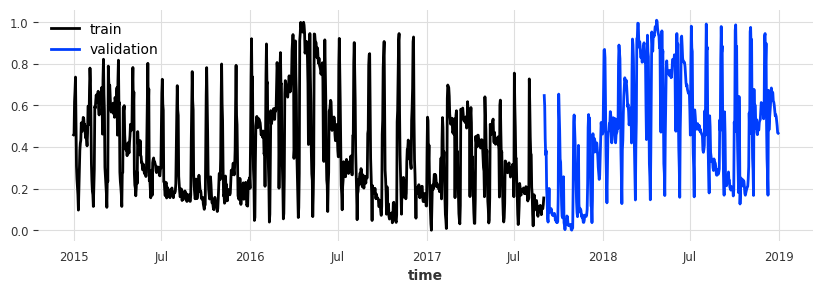

In [7]:
plt.figure(figsize=(10, 3))
train_en_transformed.plot(label="train")
val_en_transformed.plot(label="validation")

In [10]:
model_name = "TCN_test"
deeptcn = TCNModel(
    dropout=0.2,
    batch_size=32,
    n_epochs=50,
    optimizer_kwargs={"lr": 1e-3},
    random_state=0,
    input_chunk_length=300,
    output_chunk_length=30,
    kernel_size=3,
    num_filters=4,
    likelihood=QuantileRegression(),
    model_name=model_name,
    save_checkpoints=True,
    force_reset=True,
    **generate_torch_kwargs(),
)

deeptcn.fit(
    series=train_en_transformed,
    past_covariates=day_series,
    val_series=val_en_transformed,
    val_past_covariates=day_series,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


You are using a CUDA device ('NVIDIA GeForce RTX 3090 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 1.4 K 
----------------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 21/21 [00:00<00:00, 170.41it/s, train_loss=0.489, val_loss=0.715]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 21/21 [00:00<00:00, 161.52it/s, train_loss=0.489, val_loss=0.715]


TCNModel(output_chunk_shift=0, kernel_size=3, num_filters=4, num_layers=None, dilation_base=2, weight_norm=False, dropout=0.2, batch_size=32, n_epochs=50, optimizer_kwargs={'lr': 0.001}, random_state=0, input_chunk_length=300, output_chunk_length=30, likelihood=QuantileRegression(quantiles: Optional[List[float]] = None), model_name=TCN_test, save_checkpoints=True, force_reset=True, pl_trainer_kwargs={'accelerator': 'gpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x7ff94052f410>]})

In [4]:
backtest_en = deeptcn.historical_forecasts(
    series=series_en_transformed,
    past_covariates=day_series,
    num_samples=50,
    start=0.7,
    forecast_horizon=30,
    stride=5,
    retrain=False,
    verbose=True,
)

  0%|          | 0/83 [00:00<?, ?it/s]

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 321.55it/s]

  8%|▊         | 7/83 [00:00<00:01, 67.55it/s]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 315.67it/s]

 18%|█▊        | 15/83 [00:00<00:00, 71.98it/s]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 312.08it/s]


 28%|██▊       | 23/83 [00:00<00:00, 73.27it/s]

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 314.34it/s]

 37%|███▋      | 31/83 [00:00<00:00, 73.72it/s]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 310.14it/s]

 47%|████▋     | 39/83 [00:00<00:00, 74.03it/s]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 317.63it/s]

 57%|█████▋    | 47/83 [00:00<00:00, 73.46it/s]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 320.84it/s]

 66%|██████▋   | 55/83 [00:00<00:00, 74.15it/s]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 317.56it/s]

 76%|███████▌  | 63/83 [00:00<00:00, 74.60it/s]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 245.27it/s]

 86%|████████▌ | 71/83 [00:00<00:00, 73.97it/s]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 310.25it/s]

 95%|█████████▌| 79/83 [00:01<00:00, 73.72it/s]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 312.96it/s]

100%|██████████| 83/83 [00:01<00:00, 73.59it/s]

In [11]:
deeptcn = TCNModel.load_from_checkpoint(model_name=model_name, best=True)

In [12]:
backtest_en = deeptcn.historical_forecasts(
    series=series_en_transformed,
    start=val_en_transformed.start_time(),
    past_covariates=day_series,
    num_samples=500,
    forecast_horizon=30,
    stride=30,
    last_points_only=False,
    retrain=False,
    verbose=True,
)
backtest_en = concatenate(backtest_en)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


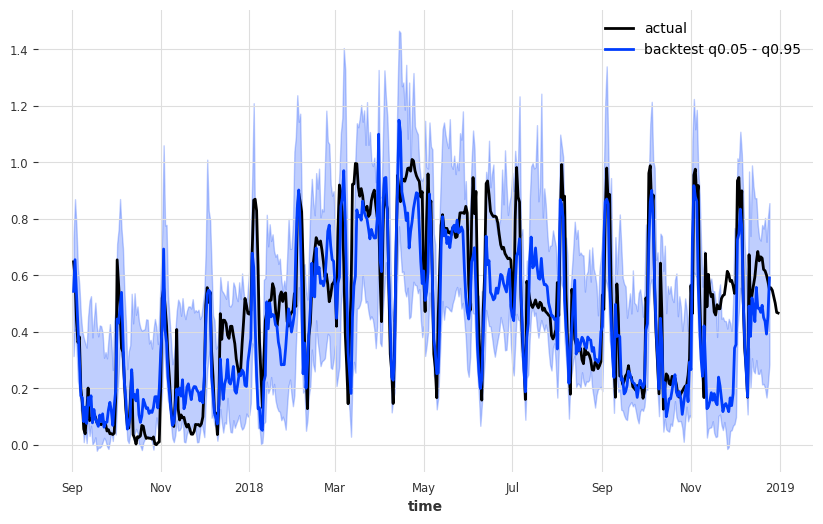

In [14]:
# plt.figure(figsize=(10, 6))
# series_en_transformed[1000:].plot(label="actual")
# backtest_en.plot(label="backtest (horizon=30)", low_quantile=0.01, high_quantile=0.99)
# plt.legend()

plt.figure(figsize=(10, 6))
val_en_transformed.plot(label="actual")
backtest_en.plot(label="backtest q0.05 - q0.95", low_quantile=0.05, high_quantile=0.95)
# backtest_en.plot(label="backtest q0.25 - q0.75", low_quantile=0.25, high_quantile=0.75)
plt.legend()